# Title: Image Classification using Sagemaker 

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

**Introduction: I will be performing Image Classification on dog breed Dataset. Here, I will be using Pretrained Image Classifier for feature extraction and then appending few fully connected layers at the end for classifying the dog breeds. Code of image classification will be implemented on train.py.**  

In [2]:
# Installing Libraries

!pip install --upgrade pip
!pip install --upgrade smdebug 
!pip install requests 
!pip install --upgrade bokeh

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached pip-23.0.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 36.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: bokeh
    Found existing installation: bokeh 1.4.0
    Uninstalling bokeh-1.4.0:
      Successfully uninstalled bokeh-1.4.0


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import pandas
import requests
import sagemaker
import boto3
from sagemaker import get_execution_role
import os
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
session = boto3.Session()


bucket= "myimageclassificationbucket"
print("Default Bucket: {}".format(bucket))

region = session.region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: myimageclassificationbucket
AWS Region: us-east-1
RoleArn: arn:aws:iam::533883467299:role/service-role/AmazonSageMaker-ExecutionRole-20230122T135976


In [ ]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip;
!unzip dogImages.zip;

# Loading Data to s3
os.chdir("dogImages")
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/
!aws s3 sync ./valid s3://${DEFAULT_S3_BUCKET}/valid/

In [24]:
os.chdir("..")

# Manual HyperParameter Tuning

In [18]:
hyperparameters = {"batch-size": "256", "epochs": "2", "lr": "0.001"}

In [19]:
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="sagemaker-script-mode",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
)

In [11]:
estimator.fit(wait=True)

2023-01-26 16:05:31 Starting - Starting the training job...
2023-01-26 16:05:48 Starting - Preparing the instances for trainingProfilerReport-1674749131: InProgress
......
2023-01-26 16:06:48 Downloading - Downloading input data...
2023-01-26 16:07:27 Training - Downloading the training image.....................
2023-01-26 16:10:54 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-26 16:11:09,690 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-26 16:11:09,719 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-01-26 16:11:09,722 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-01-26 16:11:09,993 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_in

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
# Defining Hyperparameters Ranges
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([64, 128]),
    "epochs": IntegerParameter(1 ,3)
    
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


role = sagemaker.get_execution_role()

In [8]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [9]:
# TODO: Fit your HP Tuner
tuner.fit() # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.....................................................................................................................................................................................................................................................................................................................!


In [10]:
from sagemaker import session

best_training_job_name = tuner.best_training_job()
print("Best Training Job Name")
print(best_training_job_name)


print()
print()
print("Hyperparameter Space")
tuner_hyperparameters = tuner.hyperparameter_ranges()
print(tuner_hyperparameters)
print()
print()



print("Best Hyperparameters Values")
sm_session = session.Session()
training_job_name = tuner.best_training_job()
desc = sm_session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
best_hyperparameters = desc['HyperParameters']
print(best_hyperparameters)

Best Training Job Name
pytorch-training-230220-1603-001-829e91c0


Hyperparameter Space
{'ContinuousParameterRanges': [{'Name': 'lr', 'MinValue': '0.001', 'MaxValue': '0.1', 'ScalingType': 'Auto'}], 'CategoricalParameterRanges': [{'Name': 'batch-size', 'Values': ['"64"', '"128"']}], 'IntegerParameterRanges': [{'Name': 'epochs', 'MinValue': '1', 'MaxValue': '3', 'ScalingType': 'Auto'}]}


Best Hyperparameters Values
{'_tuning_objective_metric': 'average test loss', 'batch-size': '"64"', 'epochs': '2', 'lr': '0.02504110549124806', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2023-02-20-16-03-11-848"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-533883467299/pytorch-training-2023-02-20-16-03-11-848/source/sourcedir.tar.gz"'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [6]:
hyperparameters = {"batch-size": '64', "epochs": '2', "lr": '0.02504110549124806'}
print(hyperparameters)

{'batch-size': '64', 'epochs': '2', 'lr': '0.02504110549124806'}


In [7]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

debugger_rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    
]

profilling_rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),

]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [8]:
model_output_location = 's3://udacitydlmybucket/{}'.format('model')
estimator = PyTorch(
    entry_point = "train_model.py",
    base_job_name = "smdebugger-dogbreed",
    role = get_execution_role(),
    instance_count = 1,
    instance_type = "ml.m5.xlarge",
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version = "py36",
    output_path=model_output_location,
    ## Debugger parameters
    rules = debugger_rules,
    debugger_hook_config = hook_config,
    ## Profilling Rules
    profiler_config = profiler_config,
    profiler_rules = profilling_rules
)

In [ ]:
estimator.fit(wait=True)

2023-02-20 18:13:40 Starting - Starting the training job...
2023-02-20 18:14:04 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-02-20 18:15:10 Downloading - Downloading input data
2023-02-20 18:15:10 Training - Downloading the training image......
2023-02-20 18:16:05 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-20 18:15:59,596 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-20 18:15:59,599 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-20 18:15:59,607 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-20 18:15:59,610 sagemaker_pytorch_container.training INFO   

In [41]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-02-20 17:34:02.097 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20cb211bb2dcf1:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://udacitydlmybucket/model/smdebugger-dogbreed-2023-02-20-17-18-36-847/debug-output


In [42]:
trial.tensor_names()

[2023-02-20 17:34:02.988 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20cb211bb2dcf1:17 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-02-20 17:34:04.017 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20cb211bb2dcf1:17 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [43]:
trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)

[0, 100, 200]

In [44]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


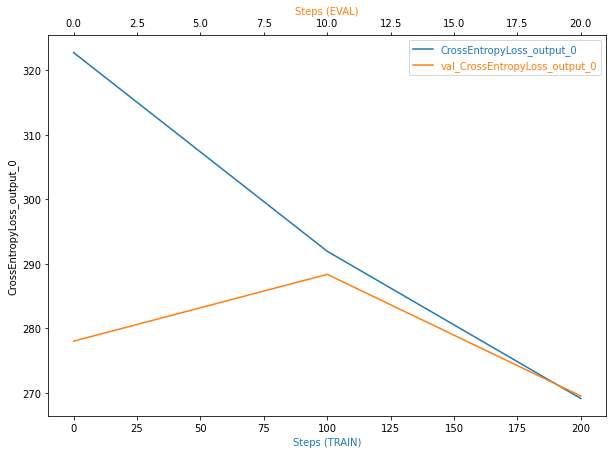

In [46]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [47]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: smdebugger-dogbreed-2023-02-20-17-18-36-847
Region: us-east-1


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?

In [48]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://udacitydlmybucket/model', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://udacitydlmybucket/model/smdebugger-dogbreed-2023-02-20-17-18-36-847/profiler-output


Profiler data from system is available


In [49]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://udacitydlmybucket/modelsmdebugger-dogbreed-2023-02-20-17-18-36-847/rule-output


In [50]:
! aws s3 ls {rule_output_path} --recursive

In [51]:
! aws s3 cp {rule_output_path} ./ --recursive

In [52]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

Image to be predicted


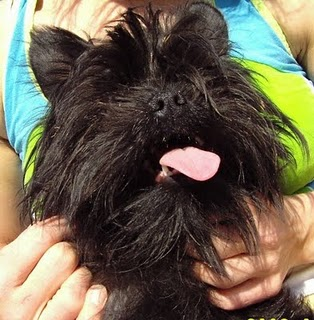

In [53]:
from PIL import Image

print("Image to be predicted")

b = Image.open("./image.jpg")

b

In [54]:
from sagemaker.pytorch import PyTorchModel
bucket = "udacitydlmybucket"
prefix = "model/smdebugger-dogbreed-2023-02-17-09-35-06-745/output"
model = PyTorchModel(
    entry_point="inference.py",
    source_dir="./",
    role=role,
    model_data='s3://{}/{}/model.tar.gz'.format(bucket, prefix),
    framework_version="1.8",
    py_version="py36",
)

In [55]:
predictor = model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [11]:
import boto3
import numpy as np
from PIL import Image
import json

sm = boto3.client('sagemaker-runtime')

# Load the image as a NumPy array
arr = np.array(Image.open("image.jpg"))

# arr1 = np.arange(0,40)

# # Create a dictionary containing the NumPy array
data = {'arr': arr.tolist()}

endpoint_name = "pytorch-inference-2023-02-20-03-28-27-416"


response = sm.invoke_endpoint(EndpointName=endpoint_name, 
                              Body=json.dumps(data),
                              ContentType='application/json')

response['Body'].read().decode('utf-8')

'{"body": [[-0.16843874752521515, -1.0235588550567627, -1.1598924398422241, -1.3945567607879639, -0.6844049096107483, -0.9287940263748169, -1.3015180826187134, -1.1474552154541016, -1.1302776336669922, -0.7409178018569946, -1.1677250862121582, -0.5755035877227783, -1.8878874778747559, -0.003688977099955082, -1.5218342542648315, -1.182648777961731, -1.7230638265609741, -1.105414867401123, -1.2473341226577759, -0.5616938471794128, -1.5176947116851807, -1.689179539680481, -1.6377840042114258, -0.8805344104766846, -2.8381340503692627, -0.769311785697937, -1.6309735774993896, -1.2980501651763916, -0.6196730732917786, -1.7921757698059082, -2.0618724822998047, -0.43197107315063477, -1.1306354999542236, -2.48720121383667, -1.1498045921325684, -1.0284814834594727, -1.325965166091919, 0.16536583006381989, -0.8122271299362183, -1.0558481216430664, -1.4885770082473755, -1.385582447052002, -1.401909351348877, -1.4819905757904053, -0.6090770363807678, -1.0280579328536987, -0.8371427655220032, -1.487

In [28]:
import boto3

s3 = boto3.client('s3')
bucket_name = 'myimageclassificationbucket'
key = 'test/001.Affenpinscher/Affenpinscher_00003.jpg'
local_filename = 'image.jpg'

s3.download_file(bucket_name, key, local_filename)

In [103]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()